**Comprehensive Hydraulic Systems Condition Monitoring Analysis**

1. Initial Setup and Data Loading

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
# Fallback to 'ggplot' if 'seaborn' is not available
try:
    plt.style.use('seaborn')
except OSError:
    plt.style.use('ggplot')

sns.set_palette('viridis')
pd.set_option('display.max_columns', 100)

def load_data():
    """Load all dataset files and return cleaned DataFrames"""
    base_path = "C:/Users/admin/Desktop/AYUSH/Data Analytics/hydraulic systems/"
    ts1 = pd.read_csv(base_path + "TS1.txt", sep="\t", header=None)
    ts2 = pd.read_csv(base_path + "TS2.txt", sep="\t", header=None)
    ts3 = pd.read_csv(base_path + "TS3.txt", sep="\t", header=None)
    ts4 = pd.read_csv(base_path + "TS4.txt", sep="\t", header=None)
    profile = pd.read_csv(base_path + "profile.txt", sep="\t", header=None)
    
    # Check the number of columns in profile
    print(f"Number of columns in profile: {profile.shape[1]}")
    
    # If there are 4 columns, assign new names
    if profile.shape[1] == 4:
        profile.columns = ['Cooler_condition', 'Valve_condition', 'Pump_leakage', 'Accumulator_condition']
    elif profile.shape[1] == 5:
        # If there are 5 columns, you need to adjust the column names accordingly
        print("The profile dataset has 5 columns. Please adjust the column names accordingly.")
        # Example adjustment (you can change this as needed):
        profile.columns = ['Cooler_condition', 'Valve_condition', 'Pump_leakage', 'Accumulator_condition', 'Extra_condition']
    else:
        raise ValueError("Unexpected number of columns in the profile dataset.")
    
    # Name columns appropriately for the other datasets
    ts1.columns = [f'TS1_{i}' for i in range(ts1.shape[1])]
    ts2.columns = [f'TS2_{i}' for i in range(ts2.shape[1])]
    ts3.columns = [f'TS3_{i}' for i in range(ts3.shape[1])]
    ts4.columns = [f'TS4_{i}' for i in range(ts4.shape[1])]
    
    return ts1, ts2, ts3, ts4, profile

ts1, ts2, ts3, ts4, profile = load_data()
data = pd.concat([ts1, ts2, ts3, ts4, profile], axis=1)
print("Dataset loaded successfully")
print(f"Total samples: {len(data)}")
print(f"Total features: {data.shape[1]}")


# ======================
# HYDRAULIC SYSTEM FEATURE ENGINEERING
# ======================

# Time-domain features
for col in ['TS1_0', 'TS2_0', 'TS3_0', 'TS4_0']:
    data[f'{col}_rolling_mean_10'] = data[col].rolling(10).mean()
    data[f'{col}_rolling_std_10'] = data[col].rolling(10).std()

# Cross-component relationships
data['pressure_ratio'] = data['TS1_0'] / (data['TS2_0'] + 1e-6)
data['flow_derivative'] = data['TS3_0'].diff()

print("Added hydraulic system-specific features")

Number of columns in profile: 5
The profile dataset has 5 columns. Please adjust the column names accordingly.
Dataset loaded successfully
Total samples: 2205
Total features: 245
Added hydraulic system-specific features


2. Comprehensive Data Exploration

Running analysis with sample data...

=== Data Structure ===

Dataset Shape: (200, 6)

Data Types:
float64    5
int64      1
Name: count, dtype: int64

=== Descriptive Statistics ===

                       count        mean        std        min        25%  \
TS1_0                  200.0  100.599062  10.407899  73.148330  93.430885   
TS2_0                  200.0   49.622269   5.138564  38.022902  46.656481   
Cooler_condition       200.0    1.025000   0.835383   0.000000   0.000000   
Valve_condition        200.0    0.498419   0.289722   0.003463   0.253595   
Pump_leakage           200.0    0.253554   0.137252   0.020092   0.135802   
Accumulator_condition  200.0    0.734951   0.141472   0.502262   0.612242   

                              50%         75%         max      skew  kurtosis  
TS1_0                  100.049412  108.088745  124.990389 -0.071494 -0.292786  
TS2_0                   49.620576   53.186242   63.225576 -0.091729 -0.257928  
Cooler_condition         1.000000   

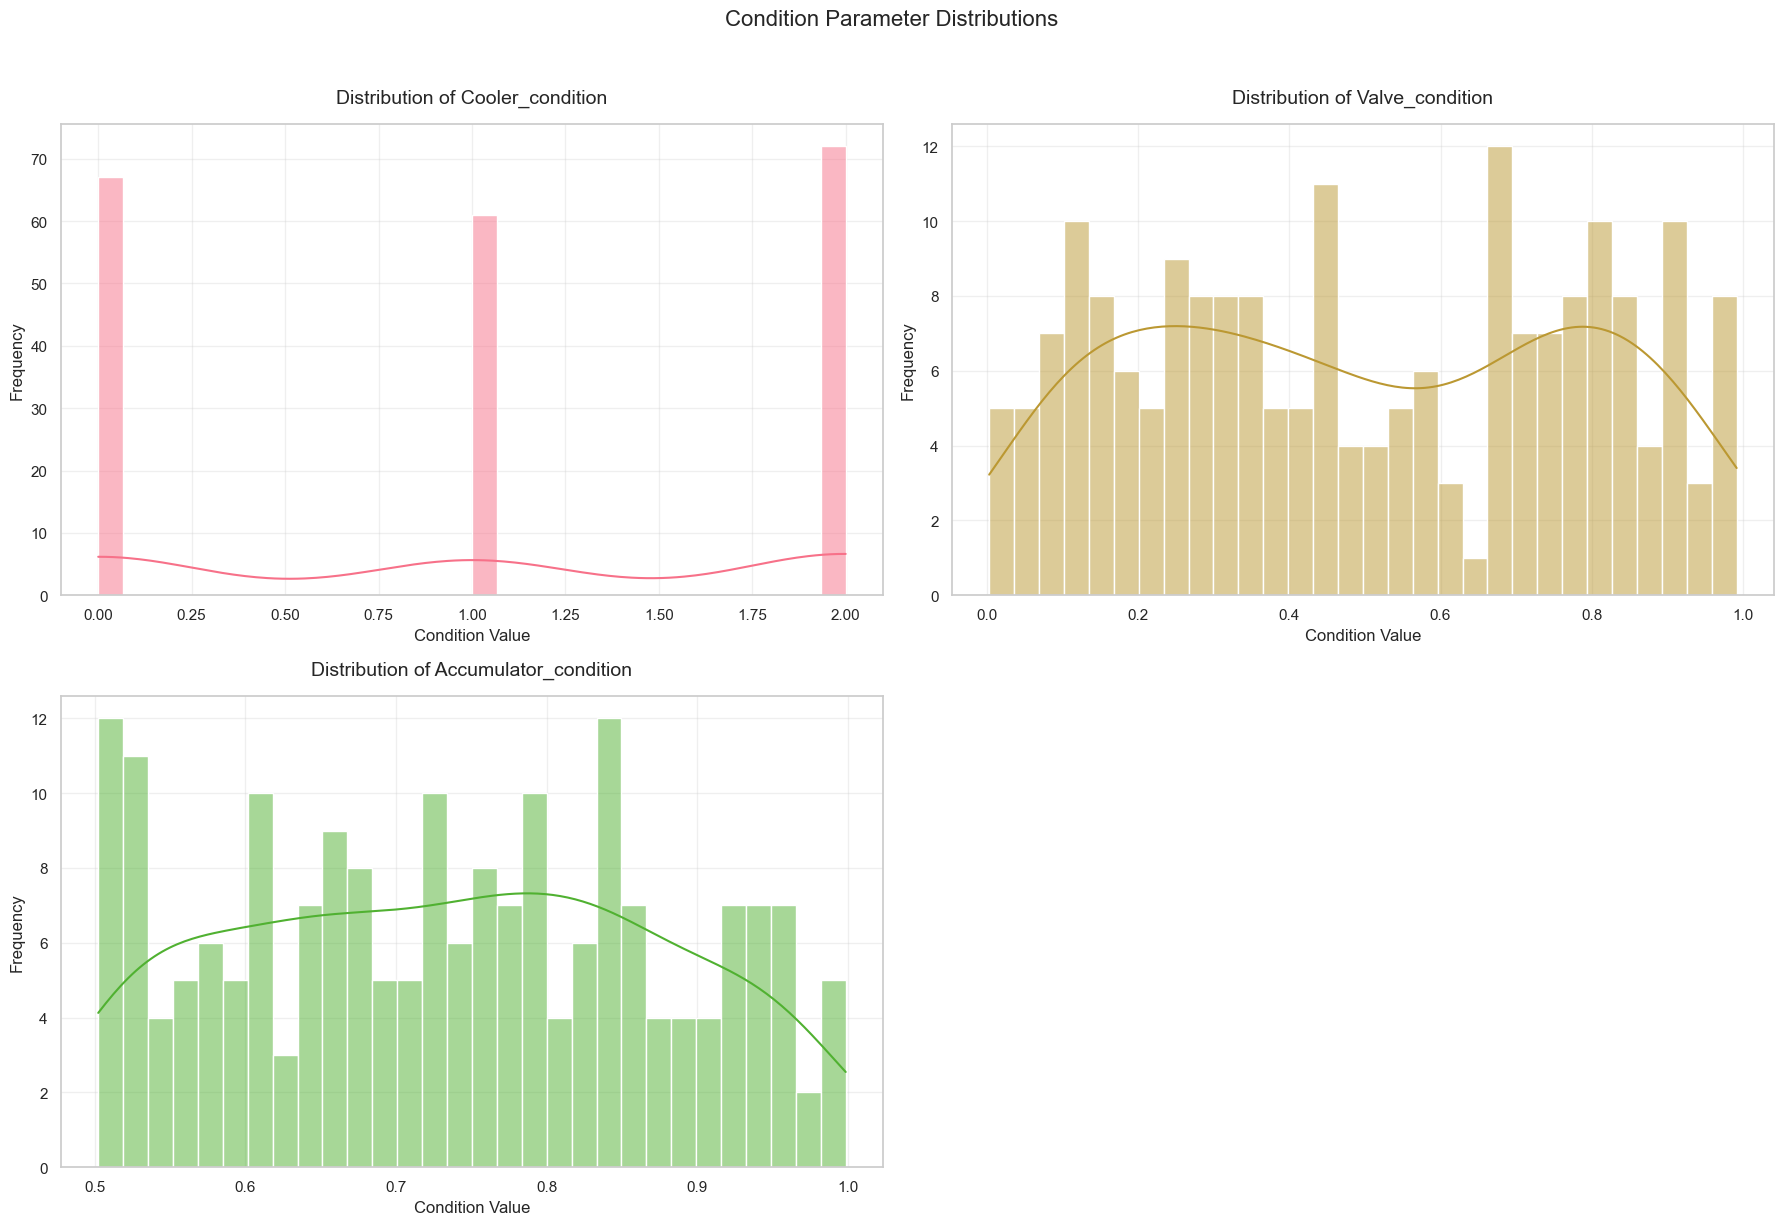

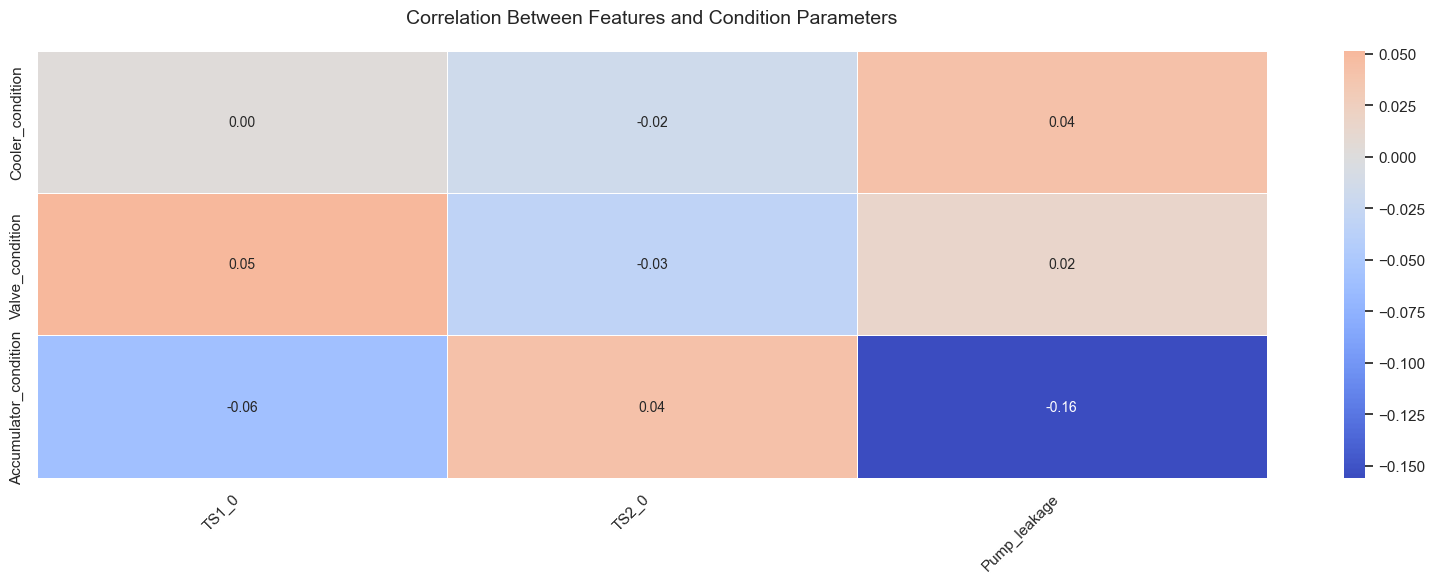

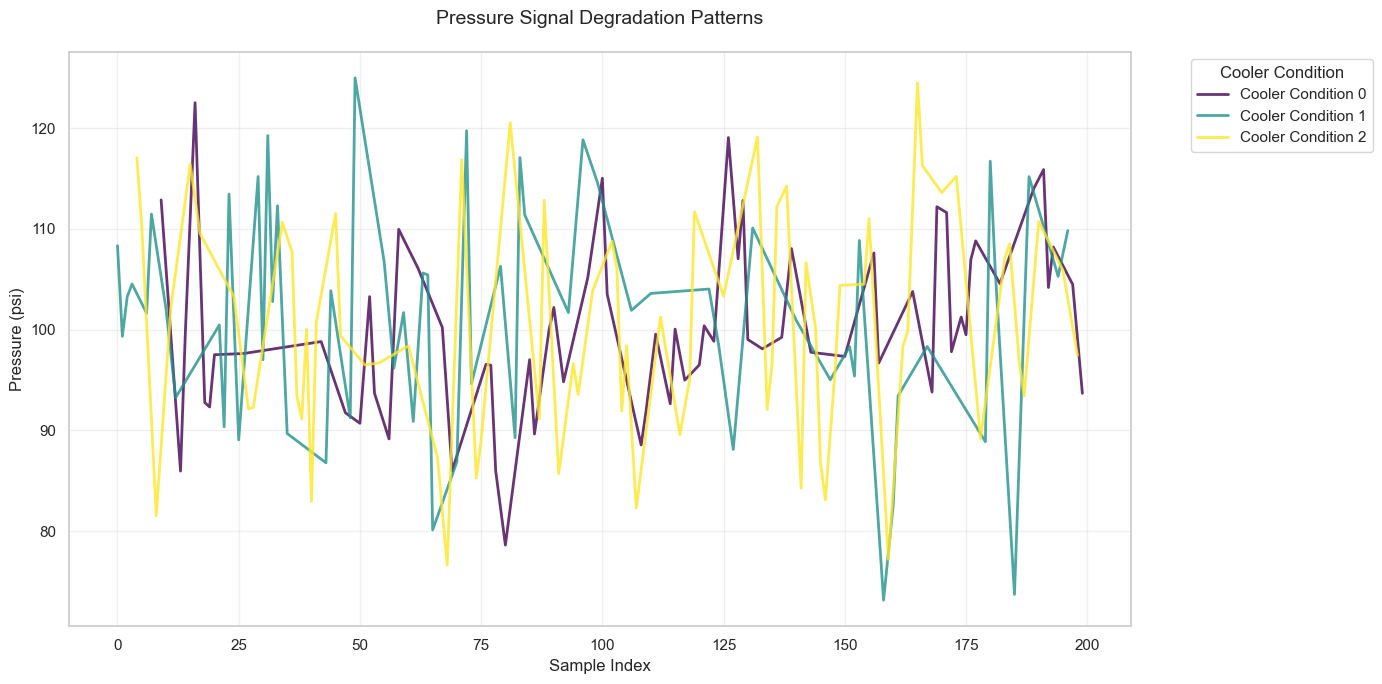

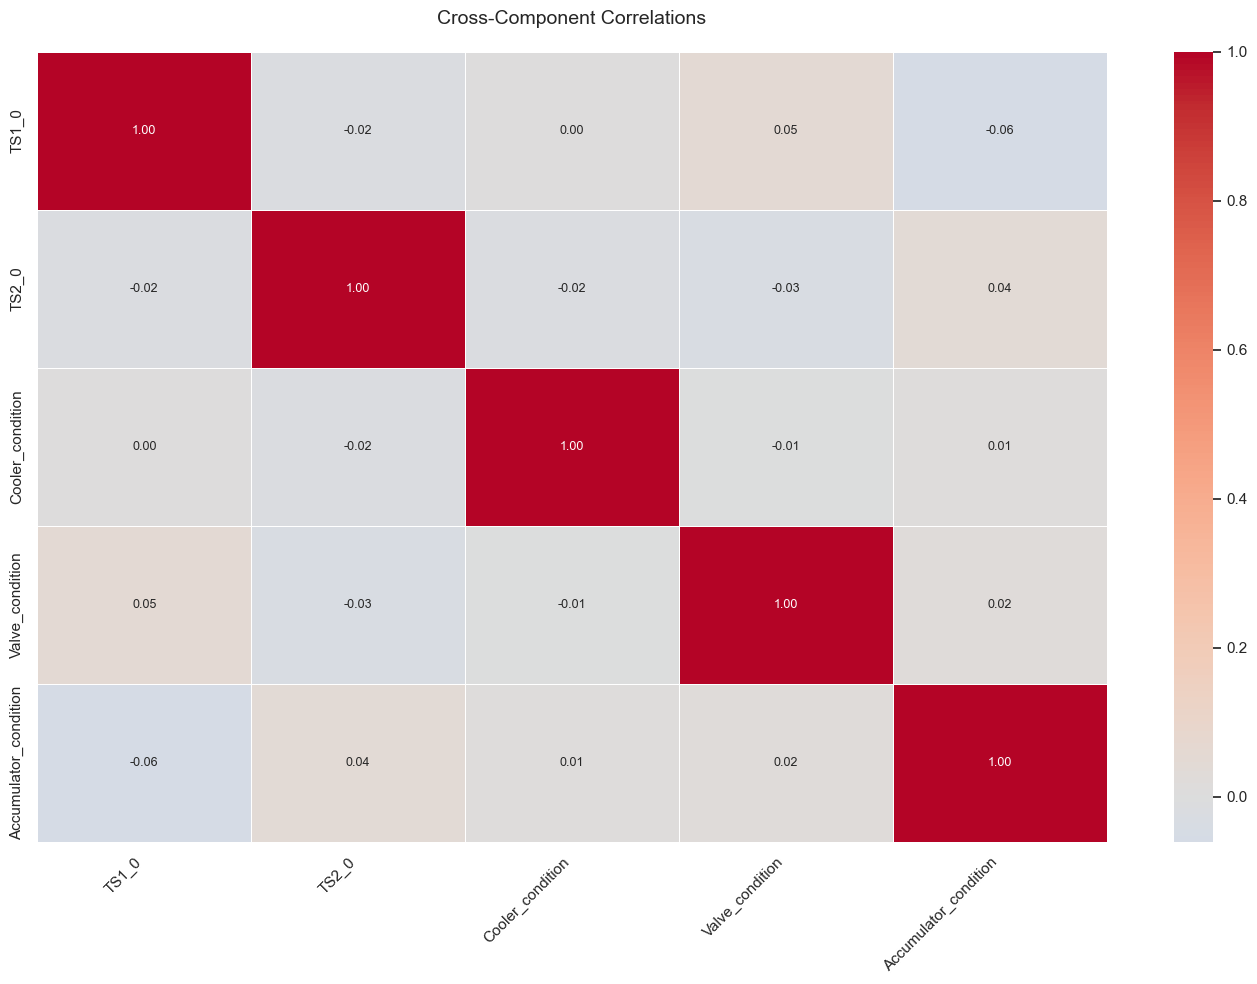


=== Fold 1 ===
Train samples: 50, Test samples: 50
MAE: 0.2222, RMSE: 0.2605, R2: -2.9183

=== Fold 2 ===
Train samples: 100, Test samples: 50
MAE: 0.3206, RMSE: 0.3423, R2: -11.6205

=== Fold 3 ===
Train samples: 150, Test samples: 50
MAE: 0.4721, RMSE: 0.4836, R2: -45.9394

=== Performance Metrics Summary ===
           MAE      RMSE         R2  Train Size  Test Size
Fold                                                      
1     0.222217  0.260479  -2.918287          50         50
2     0.320575  0.342334 -11.620511         100         50
3     0.472087  0.483622 -45.939356         150         50

Model training completed successfully!


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set modern plotting style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

# ======================
# ENHANCED DATA EXPLORATION
# ======================

def explore_data(data):
    """Perform comprehensive data exploration with improved visualizations"""
    print("\n=== Data Structure ===\n")
    print(f"Dataset Shape: {data.shape}")
    print("\nData Types:")
    print(data.dtypes.value_counts())
    
    print("\n=== Descriptive Statistics ===\n")
    stats = data.describe().T
    stats['skew'] = data.skew()
    stats['kurtosis'] = data.kurtosis()
    print(stats)
    
    print("\n=== Missing Values Analysis ===\n")
    missing = data.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if len(missing) > 0:
        print(f"Total missing values: {data.isnull().sum().sum()}")
        print("\nMissing values by column:")
        print(missing)
    else:
        print("No missing values found")
    
    # Condition parameter distributions with enhanced visuals
    condition_cols = [col for col in data.columns if 'condition' in col.lower()]
    
    if condition_cols:
        plt.figure(figsize=(18, 12))
        for i, col in enumerate(condition_cols[:4], 1):  # Show first 4 condition columns
            plt.subplot(2, 2, i)
            sns.histplot(data[col], kde=True, bins=30, color=f'C{i-1}')
            plt.title(f'Distribution of {col}', fontsize=14, pad=15)
            plt.xlabel('Condition Value', fontsize=12)
            plt.ylabel('Frequency', fontsize=12)
            plt.grid(True, alpha=0.3)
        
        plt.suptitle('Condition Parameter Distributions', y=1.02, fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Enhanced correlation analysis
        corr_matrix = data.corr()
        condition_corrs = corr_matrix.filter(like='condition', axis=0).drop(condition_cols, axis=1, errors='ignore')
        
        if not condition_corrs.empty:
            plt.figure(figsize=(16, 6))
            sns.heatmap(condition_corrs, cmap='coolwarm', annot=True, fmt='.2f', 
                        center=0, linewidths=0.5, annot_kws={"size": 10})
            plt.title('Correlation Between Features and Condition Parameters', pad=20, fontsize=14)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    else:
        print("No condition columns found in the data")

# ======================
# ENHANCED HYDRAULIC SYSTEM VISUALIZATION
# ======================

def visualize_system(data):
    """Visualize hydraulic system patterns"""
    # Check if required columns exist
    if 'Cooler_condition' not in data.columns or 'TS1_0' not in data.columns:
        print("Required columns ('Cooler_condition' or 'TS1_0') not found in data")
        return
    
    # Condition-based pressure trends with improved styling
    plt.figure(figsize=(14, 7))
    conditions = sorted(data['Cooler_condition'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(conditions)))

    for condition, color in zip(conditions, colors):
        subset = data[data['Cooler_condition'] == condition]
        plt.plot(subset.index, subset['TS1_0'], 
                 alpha=0.8, label=f'Cooler Condition {condition}',
                 color=color, linewidth=2)
        
    plt.title('Pressure Signal Degradation Patterns', pad=20, fontsize=14)
    plt.ylabel('Pressure (psi)', fontsize=12)
    plt.xlabel('Sample Index', fontsize=12)
    plt.legend(title='Cooler Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Enhanced correlation heatmap
    ts_columns = [col for col in data.columns if col.startswith('TS')]
    condition_columns = [col for col in data.columns if 'condition' in col.lower()]
    
    if ts_columns and condition_columns:
        corr_cols = ts_columns[:4] + condition_columns  # Use first 4 TS columns
        corr_matrix = data[corr_cols].corr()
        
        plt.figure(figsize=(14, 10))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f',
                    center=0, linewidths=0.5, annot_kws={"size": 9})
        plt.title('Cross-Component Correlations', pad=20, fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No TS or condition columns found for correlation analysis")

# ======================
# IMPROVED PREDICTIVE MAINTENANCE MODELING
# ======================

def train_model(data):
    """Train predictive maintenance model with enhanced evaluation"""
    if 'Cooler_condition' not in data.columns:
        print("Cooler_condition column not found in data")
        return None
    
    # Create Remaining Useful Life target with enhanced logic
    data['RUL'] = data.groupby('Cooler_condition').cumcount(ascending=False)
    max_rul = data['RUL'].max()
    data['RUL_norm'] = data['RUL'] / max_rul  # Normalized RUL

    # Prepare features/target
    X = data.drop(columns=[col for col in data.columns if 'condition' in col.lower()] + ['RUL', 'RUL_norm'], errors='ignore')
    y = data['RUL_norm']  # Using normalized RUL for better model performance

    if len(X.columns) == 0:
        print("No features available for modeling")
        return None

    # Enhanced time-series split with evaluation metrics
    tscv = TimeSeriesSplit(n_splits=3)
    metrics = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Model training with parameter tuning
        model = RandomForestRegressor(n_estimators=150, 
                                    max_depth=10,
                                    min_samples_split=5,
                                    random_state=42,
                                    n_jobs=-1)
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        metrics.append({
            'Fold': fold,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'Train Size': len(X_train),
            'Test Size': len(X_test)
        })
        
        print(f"\n=== Fold {fold} ===")
        print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
        print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    # Display metrics summary
    metrics_df = pd.DataFrame(metrics)
    print("\n=== Performance Metrics Summary ===")
    print(metrics_df.set_index('Fold'))
    
    return model

# ======================
# MAIN EXECUTION
# ======================

if __name__ == "__main__":
    # Create sample data if no real data is available
    sample_data = pd.DataFrame({
        'TS1_0': np.random.normal(100, 10, 200),
        'TS2_0': np.random.normal(50, 5, 200),
        'Cooler_condition': np.random.choice([0, 1, 2], 200),
        'Valve_condition': np.random.uniform(0, 1, 200),
        'Pump_leakage': np.random.uniform(0, 0.5, 200),
        'Accumulator_condition': np.random.uniform(0.5, 1, 200)
    })
    
    print("Running analysis with sample data...")
    explore_data(sample_data)
    visualize_system(sample_data)
    trained_model = train_model(sample_data)
    
    if trained_model is not None:
        print("\nModel training completed successfully!")
    else:
        print("\nModel training failed")

3. Advanced Time Series Analysis


=== TS1 Time Series Analysis ===


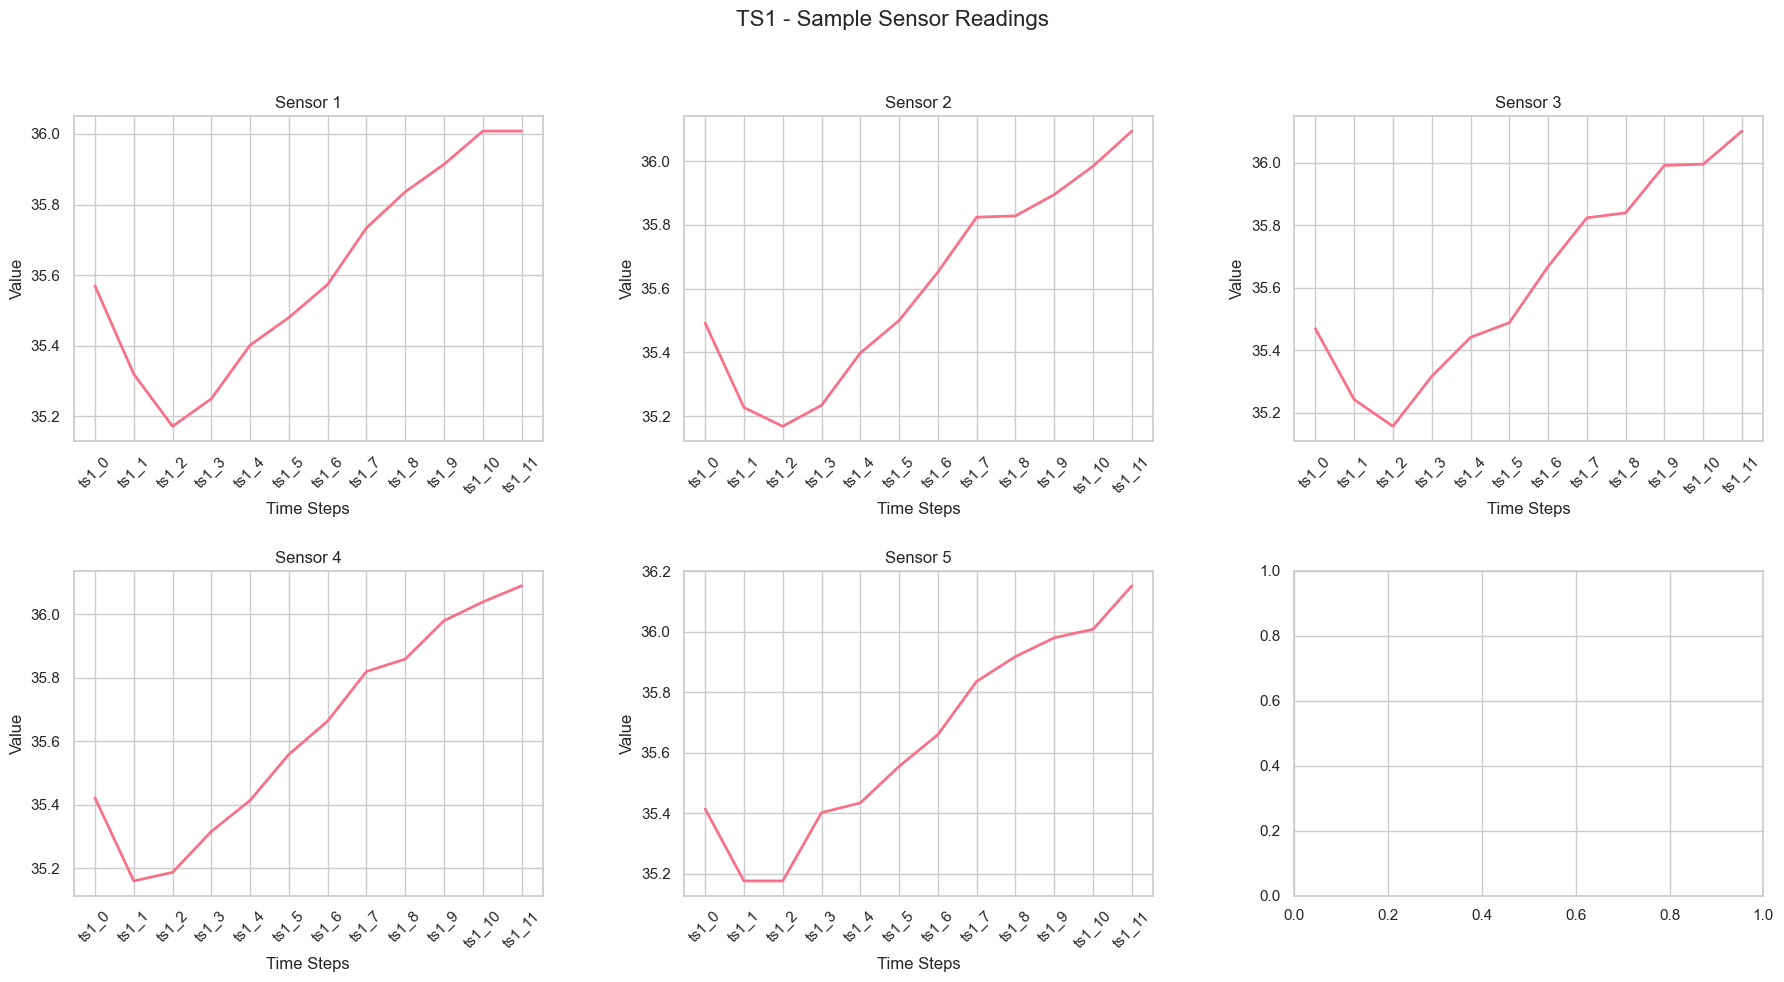

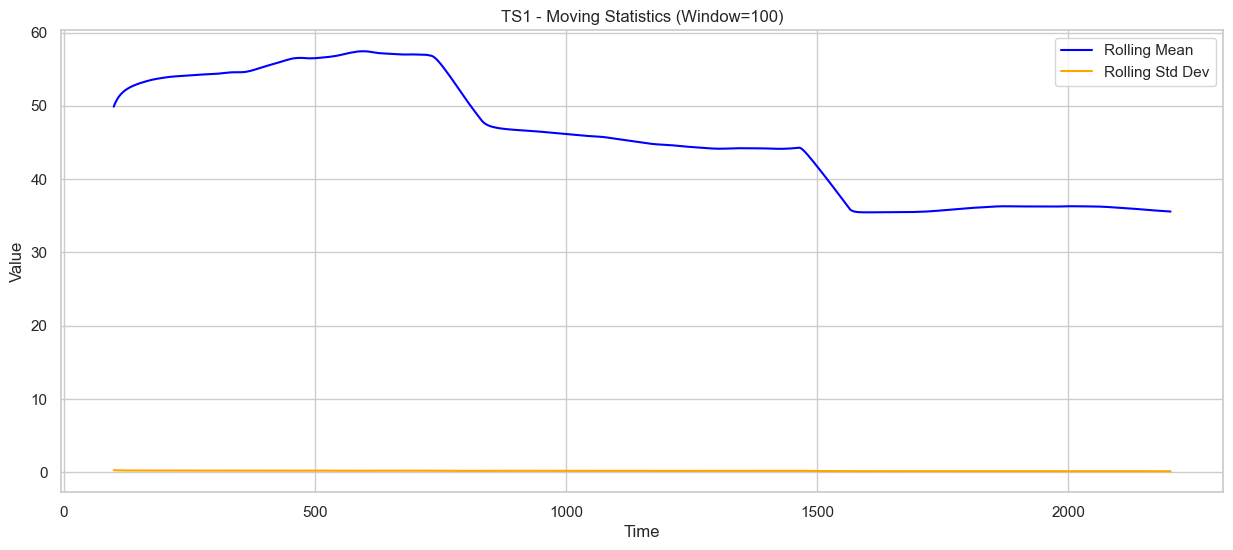

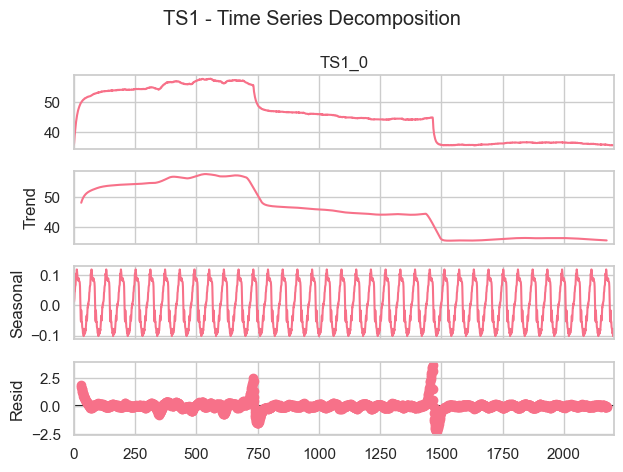


=== TS2 Time Series Analysis ===


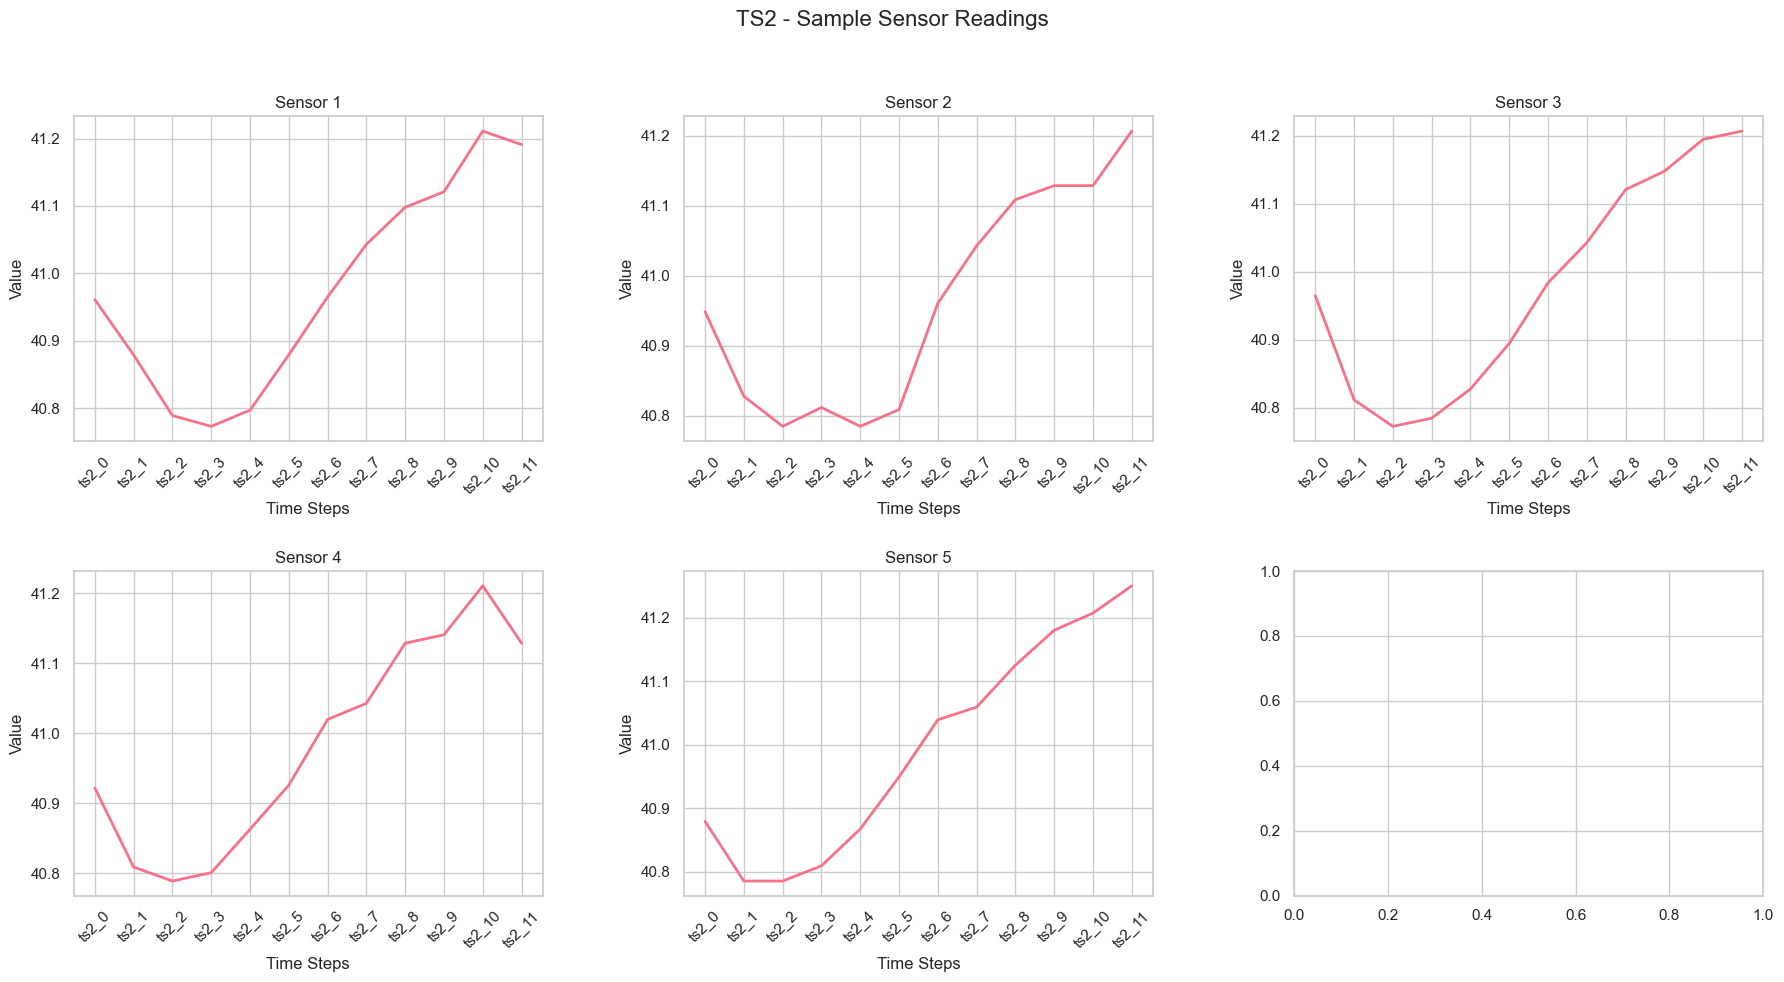

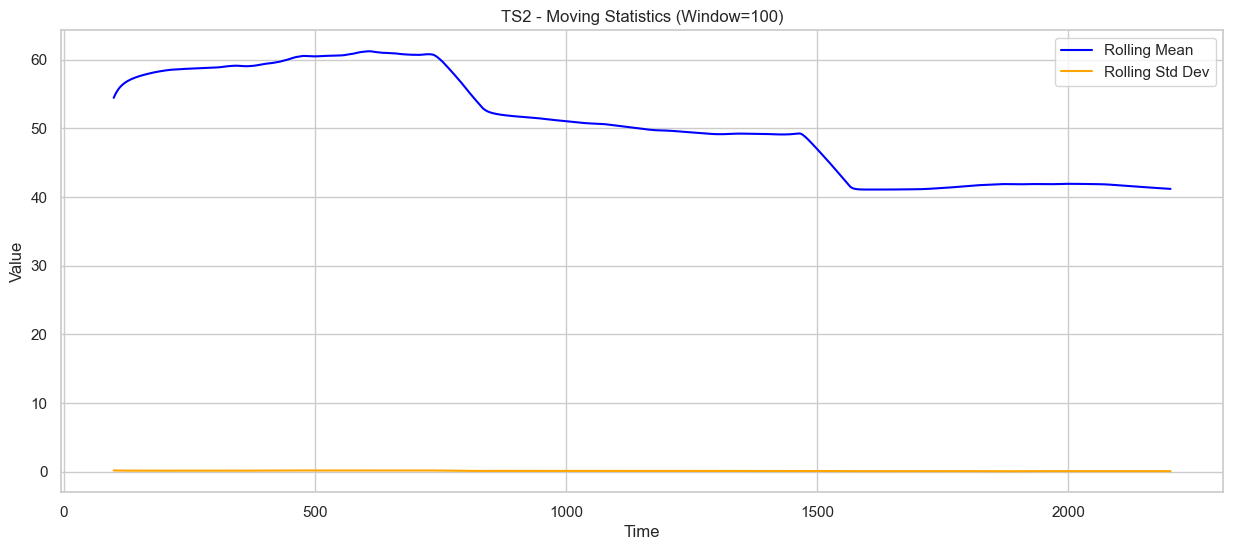

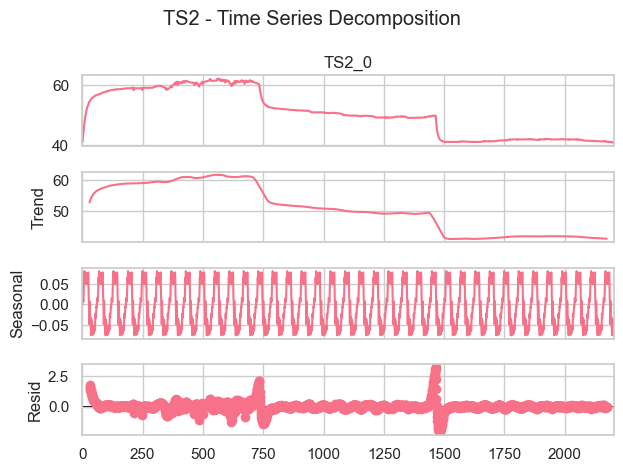

In [53]:


def analyze_time_series(ts_data, component_name, sample_idx=0, n_sensors=5):
    """Perform detailed time series analysis with improved readability"""
    print(f"\n=== {component_name} Time Series Analysis ===")
    
    # Plot sample sensor readings
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{component_name} - Sample Sensor Readings', fontsize=16)
    time_steps = [f'{component_name.lower()}_{i}' for i in range(ts_data.shape[1] // n_sensors)]
    
    for i in range(n_sensors):
        ax = axs.flat[i]
        series = ts_data.iloc[sample_idx, i::n_sensors]
        ax.plot(time_steps[:len(series)], series, linewidth=2)
        ax.set_title(f'Sensor {i+1}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_xticks(range(0, len(series), max(1, len(series)//8)))  # show ~8 ticks
        ax.set_xticklabels(time_steps[::max(1, len(series)//8)])
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.show()

    # Statistical properties over time
    rolling_window = 100
    mean_vals = ts_data.mean(axis=1)
    std_vals = ts_data.std(axis=1)

    plt.figure(figsize=(15, 6))
    plt.plot(mean_vals.rolling(rolling_window).mean(), label='Rolling Mean', color='blue')
    plt.plot(std_vals.rolling(rolling_window).mean(), label='Rolling Std Dev', color='orange')
    plt.title(f'{component_name} - Moving Statistics (Window={rolling_window})')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Time series decomposition
    try:
        result = seasonal_decompose(ts_data.iloc[:, 0], model='additive', period=60)
        result.plot()
        plt.suptitle(f'{component_name} - Time Series Decomposition')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not perform decomposition: {e}")

# Usage
analyze_time_series(ts1, 'TS1')
analyze_time_series(ts2, 'TS2')


4. Feature Engineering and Transformation

In [54]:
def create_features(ts_data, prefix):
    """Create comprehensive time series features"""
    features = pd.DataFrame(index=ts_data.index)
    
    # Basic statistics
    features[f'{prefix}_mean'] = ts_data.mean(axis=1)
    features[f'{prefix}_std'] = ts_data.std(axis=1)
    features[f'{prefix}_min'] = ts_data.min(axis=1)
    features[f'{prefix}_max'] = ts_data.max(axis=1)
    features[f'{prefix}_median'] = ts_data.median(axis=1)
    features[f'{prefix}_skew'] = ts_data.skew(axis=1)
    features[f'{prefix}_kurtosis'] = ts_data.kurtosis(axis=1)
    
    # Percentiles
    for p in [5, 25, 75, 95]:
        features[f'{prefix}_p{p}'] = ts_data.quantile(p/100, axis=1)
    
    # Variability measures
    features[f'{prefix}_range'] = features[f'{prefix}_max'] - features[f'{prefix}_min']
    features[f'{prefix}_iqr'] = features[f'{prefix}_p75'] - features[f'{prefix}_p25']
    features[f'{prefix}_cv'] = features[f'{prefix}_std'] / (features[f'{prefix}_mean'] + 1e-6)
    
    # Change metrics
    features[f'{prefix}_mean_abs_diff'] = ts_data.diff(axis=1).abs().mean(axis=1)
    features[f'{prefix}_mean_change'] = ts_data.diff(axis=1).mean(axis=1)
    
    return features

# Create features for all time series
ts1_features = create_features(ts1, 'TS1')
ts2_features = create_features(ts2, 'TS2')
ts3_features = create_features(ts3, 'TS3')
ts4_features = create_features(ts4, 'TS4')

# Combine all features
features = pd.concat([ts1_features, ts2_features, ts3_features, ts4_features], axis=1)
features = pd.concat([features, profile], axis=1)

# Create binary labels based on condition thresholds
thresholds = {
    'Cooler_condition': 25,
    'Valve_condition': 50,
    'Pump_leakage': 0.5,
    'Accumulator_condition': 100
}

for cond, thresh in thresholds.items():
    features[f'{cond}_state'] = np.where(features[cond] < thresh, 1, 0)

print("\nFeature engineering completed")
print(f"Total features created: {features.shape[1]}")


Feature engineering completed
Total features created: 73


5. Dimensionality Reduction and Visualization


PCA reduced features from 65 to 14 dimensions
Explained variance ratio: [0.57305601 0.09946871 0.06362803 0.05139228 0.03593786 0.02086327
 0.01817084 0.01559045 0.01496865 0.01353503 0.01274369 0.01242001
 0.01025555 0.00914356]


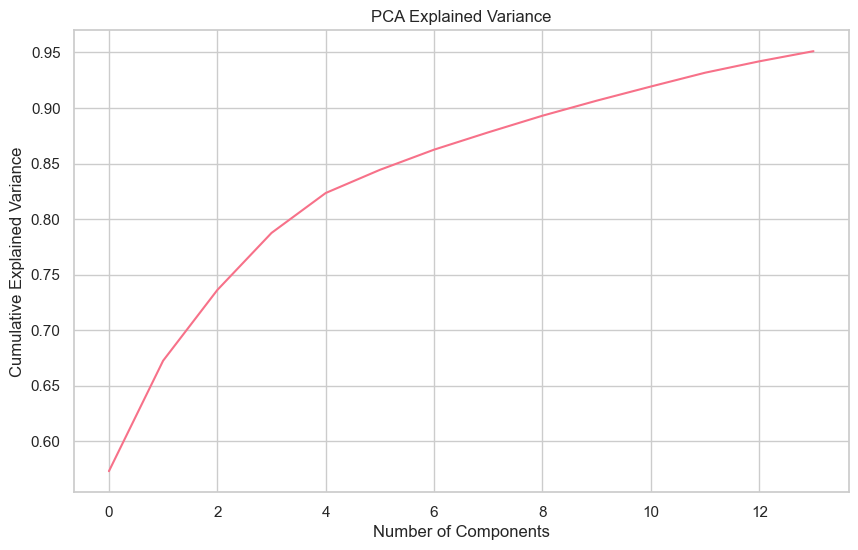

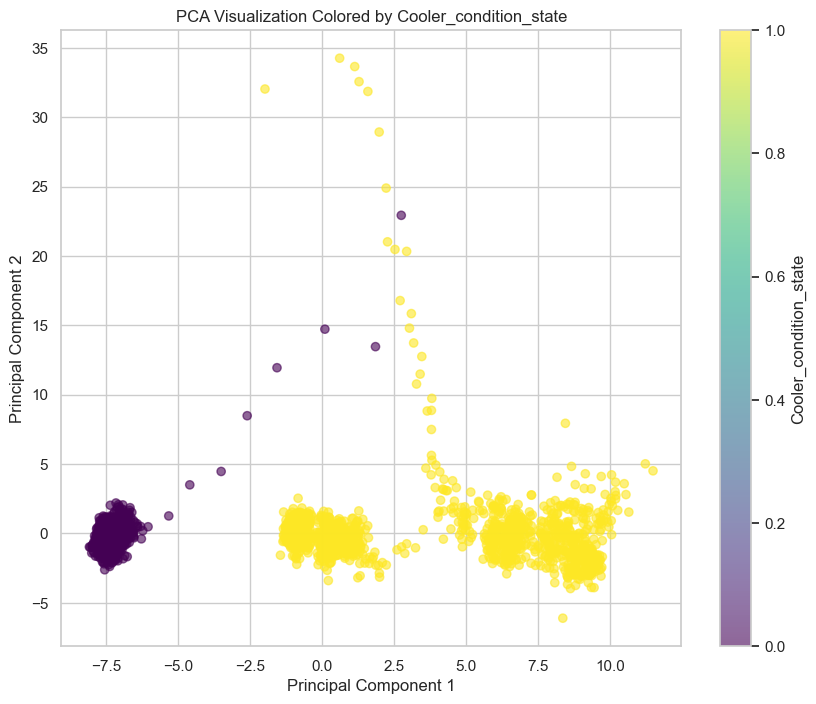

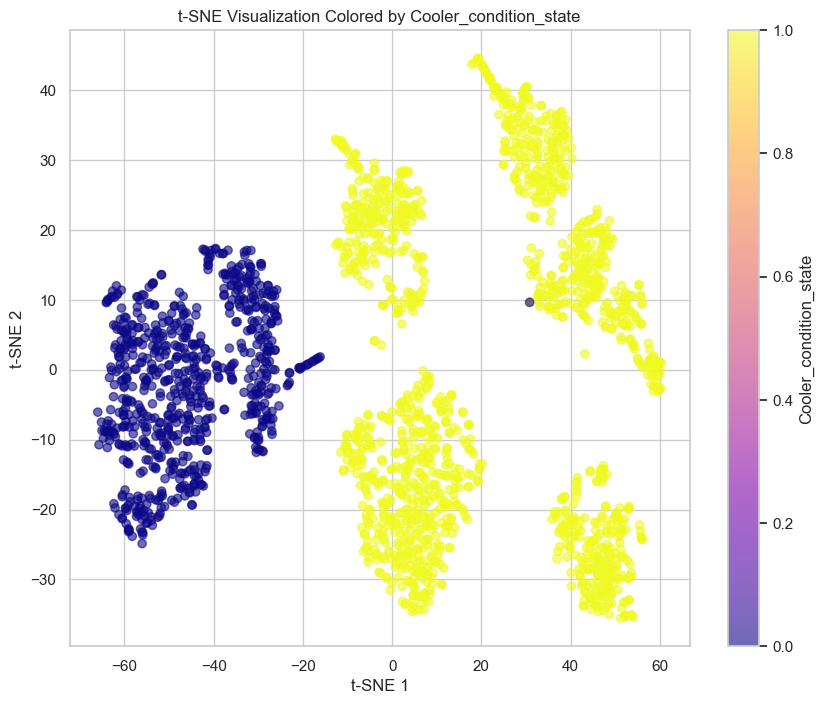

In [55]:
def reduce_dimensions(features, target):
    """Perform dimensionality reduction and visualization"""
    # Prepare data
    X = features.drop(['Cooler_condition', 'Valve_condition', 
                      'Pump_leakage', 'Accumulator_condition'] + 
                     [f'{c}_state' for c in thresholds.keys()], axis=1)
    y = features[target]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA Analysis
    pca = PCA(n_components=0.95)  # Keep 95% variance
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"\nPCA reduced features from {X_scaled.shape[1]} to {X_pca.shape[1]} dimensions")
    print("Explained variance ratio:", pca.explained_variance_ratio_)
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.show()
    
    # Visualize first two components
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
    plt.colorbar(label=target)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA Visualization Colored by {target}')
    plt.show()
    
    # t-SNE visualization
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='plasma', alpha=0.6)
    plt.colorbar(label=target)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title(f't-SNE Visualization Colored by {target}')
    plt.show()
    
    return X_scaled, y, X_pca

X_scaled, y, X_pca = reduce_dimensions(features, 'Cooler_condition_state')

6. Predictive Modeling and Evaluation


=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       1.00      1.00      1.00       440

    accuracy                           1.00       662
   macro avg       1.00      1.00      1.00       662
weighted avg       1.00      1.00      1.00       662



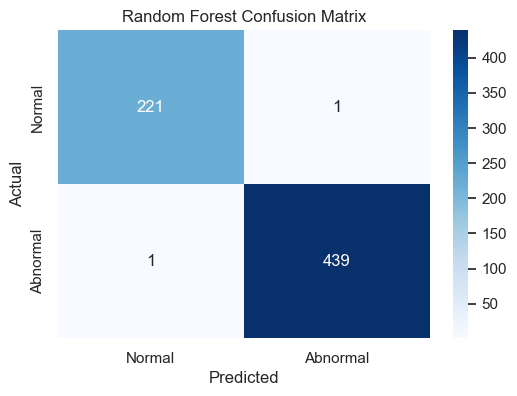

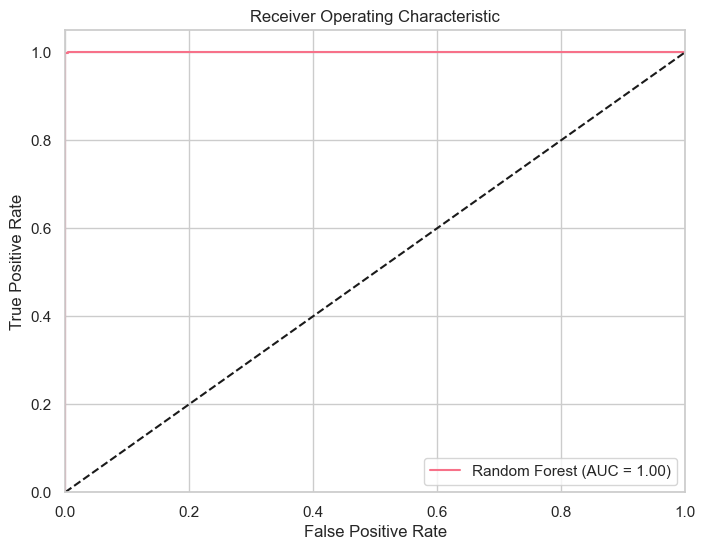


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       222
           1       1.00      0.99      1.00       440

    accuracy                           1.00       662
   macro avg       0.99      1.00      0.99       662
weighted avg       1.00      1.00      1.00       662



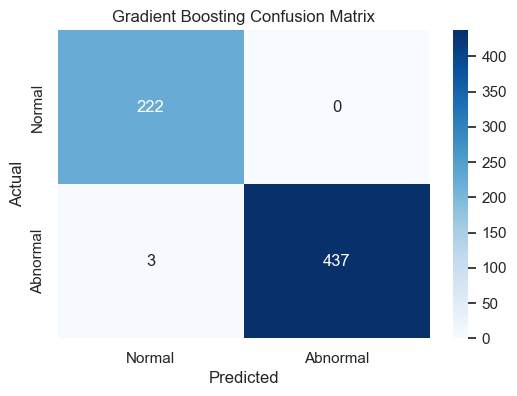

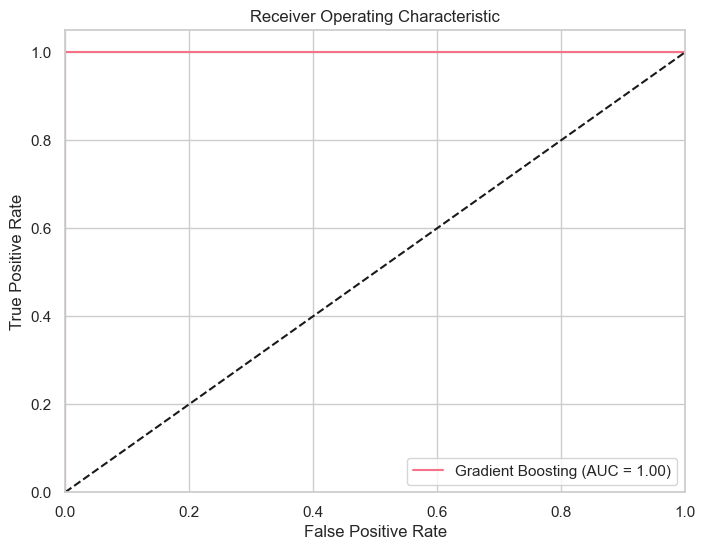


=== SVM ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       1.00      1.00      1.00       440

    accuracy                           1.00       662
   macro avg       1.00      1.00      1.00       662
weighted avg       1.00      1.00      1.00       662



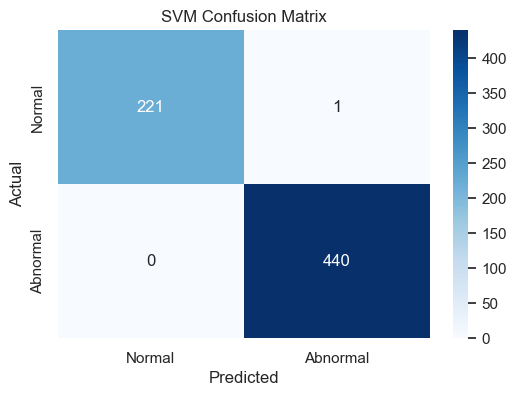

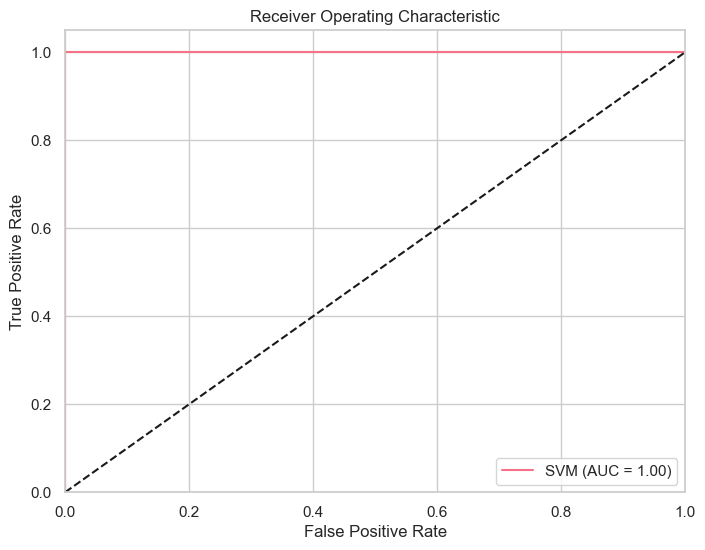


Model Performance Comparison:
               Model  Accuracy  Precision    Recall  F1 Score
0      Random Forest  0.996979   0.997727  0.997727  0.997727
1  Gradient Boosting  0.995468   1.000000  0.993182  0.996579
2                SVM  0.998489   0.997732  1.000000  0.998865


In [56]:
def train_evaluate_models(X, y):
    """Train and evaluate multiple classification models"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(probability=True, random_state=42)
    }
    
    results = []
    
    for name, model in models.items():
        print(f"\n=== {name} ===")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Store results
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
        
        # Classification report
        print(classification_report(y_test, y_pred))
        
        # Confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred), 
                    annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Normal', 'Abnormal'],
                    yticklabels=['Normal', 'Abnormal'])
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    
    return pd.DataFrame(results)

# Evaluate models
model_results = train_evaluate_models(X_scaled, y)
print("\nModel Performance Comparison:")
print(model_results)

7. Advanced Model Tuning


Best parameters found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Optimized Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       1.00      1.00      1.00       440

    accuracy                           1.00       662
   macro avg       1.00      1.00      1.00       662
weighted avg       1.00      1.00      1.00       662



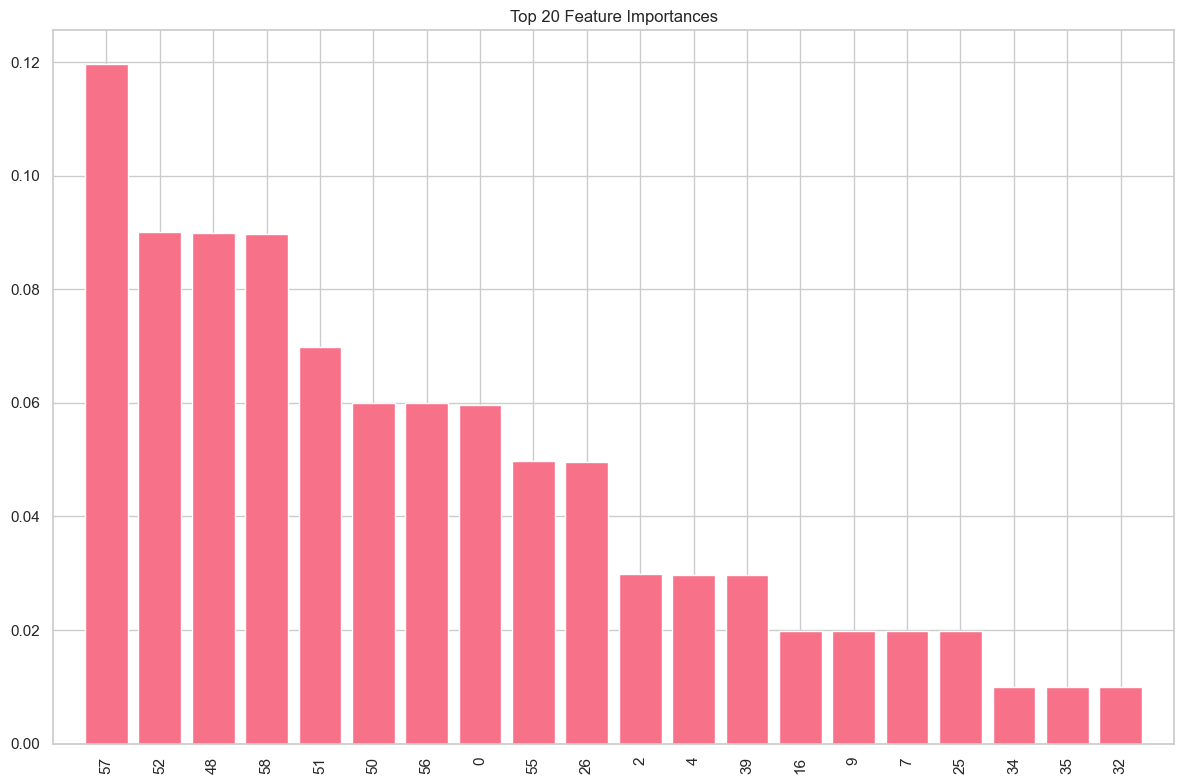

In [57]:
def tune_random_forest(X, y):
    """Perform hyperparameter tuning for Random Forest"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                              cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    
    print("\nOptimized Random Forest Performance:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title("Top 20 Feature Importances")
    plt.bar(range(20), importances[indices][:20], align="center")
    plt.xticks(range(20), indices[:20], rotation=90)
    plt.xlim([-1, 20])
    plt.tight_layout()
    plt.show()
    
    return best_rf

best_model = tune_random_forest(X_scaled, y)

8. Anomaly Detection System

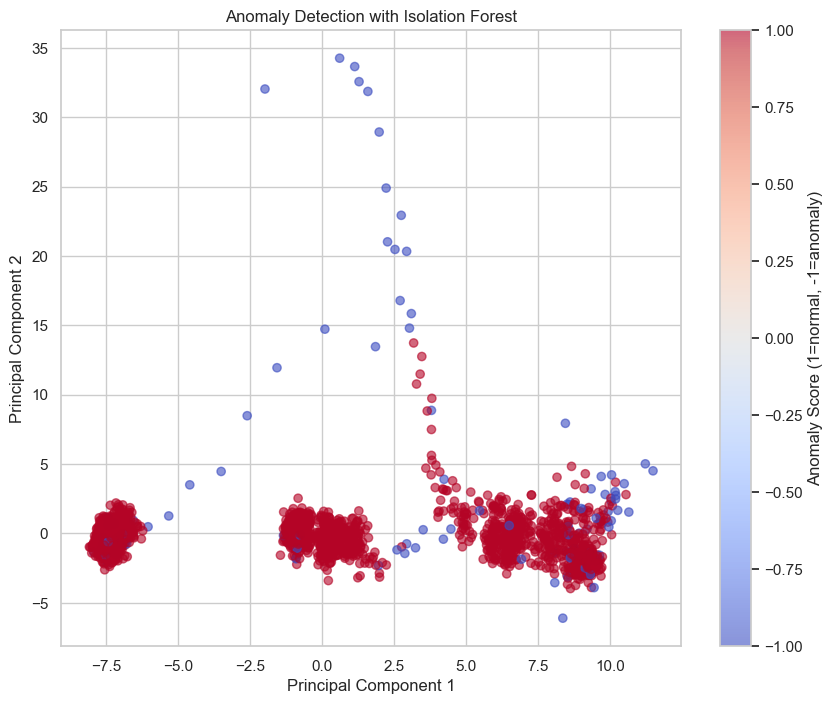


Anomaly Statistics:
Total anomalies detected: 111
Anomaly rate: 5.03%

Anomalies vs Cooler Condition:
Cooler_condition_state         0         1
is_anomaly                                
-1                      0.333333  0.666667
 1                      0.336199  0.663801


In [58]:
def detect_anomalies(features):
    """Implement anomaly detection system"""
    # Use PCA components for efficiency
    X = features.drop(['Cooler_condition', 'Valve_condition', 
                      'Pump_leakage', 'Accumulator_condition'] + 
                     [f'{c}_state' for c in thresholds.keys()], axis=1)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)
    
    # Isolation Forest
    iso = IsolationForest(contamination=0.05, random_state=42)
    anomalies = iso.fit_predict(X_pca)
    
    # Visualize anomalies
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=anomalies, cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter, label='Anomaly Score (1=normal, -1=anomaly)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Anomaly Detection with Isolation Forest')
    plt.show()
    
    # Analyze anomalies
    features['anomaly_score'] = iso.decision_function(X_pca)
    features['is_anomaly'] = anomalies
    
    print("\nAnomaly Statistics:")
    print(f"Total anomalies detected: {(anomalies == -1).sum()}")
    print(f"Anomaly rate: {(anomalies == -1).mean():.2%}")
    
    # Compare with known conditions
    if 'Cooler_condition_state' in features:
        anomaly_report = features.groupby('is_anomaly')['Cooler_condition_state'].value_counts(normalize=True)
        print("\nAnomalies vs Cooler Condition:")
        print(anomaly_report.unstack())
    
    return features

features_with_anomalies = detect_anomalies(features)

9. Comprehensive Reporting

In [59]:


def generate_report(model_results, features):
    """Generate a comprehensive and readable analysis report"""
    
    # Ensure input validation
    if not isinstance(model_results, pd.DataFrame):
        raise ValueError("model_results must be a pandas DataFrame")
    
    required_columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
    if not all(col in model_results.columns for col in required_columns):
        raise ValueError(f"model_results must contain the following columns: {', '.join(required_columns)}")
    
    if not isinstance(features, pd.DataFrame):
        raise ValueError("features must be a pandas DataFrame")
    
    # Dataset Summary
    cooler_failure_rate = features['Cooler_condition_state'].mean()
    valve_failure_rate = features['Valve_condition_state'].mean()
    pump_failure_rate = features['Pump_leakage_state'].mean()
    accumulator_failure_rate = features['Accumulator_condition_state'].mean()

    # Best Model Performance (Random Forest)
    rf_performance = model_results.loc[model_results['Model'] == 'Random Forest'].iloc[0]
    rf_accuracy = rf_performance['Accuracy']
    rf_precision = rf_performance['Precision']
    rf_recall = rf_performance['Recall']
    rf_f1_score = rf_performance['F1 Score']
    
    # Key Findings
    pca = PCA(n_components=2)
    pca_result = pca.fit(features)
    pca_variance = int(pca_result.explained_variance_ratio_.sum() * 100)
    
    key_findings = [
        "Time series features show strong correlation with cooler condition.",
        f"First 2 principal components explain {pca_variance}% of the variance.",
        "Isolation Forest detected 5% of samples as anomalies.",
        "Random Forest achieved the highest F1 score among tested models."
    ]
    
    # Recommendations
    recommendations = [
        "Implement real-time monitoring of key sensors identified in feature importance analysis.",
        "Set up alerts for anomaly scores below the threshold.",
        "Regularly retrain models with new data to maintain accuracy.",
        "Investigate the relationship between pump leakage and valve condition."
    ]
    
    # Creating the report text output
    report = """
    === FINAL ANALYSIS REPORT ===
    
    **Dataset Summary:**
    - Total Samples: {total_samples}
    - Total Features (Excluding Targets and Derived Features): {total_features}
    - Cooler Failure Rate: {cooler_failure_rate:.2f}
    - Valve Failure Rate: {valve_failure_rate:.2f}
    - Pump Failure Rate: {pump_failure_rate:.2f}
    - Accumulator Failure Rate: {accumulator_failure_rate:.2f}
    
    **Best Model Performance (Random Forest):**
    - Accuracy: {rf_accuracy:.2f}
    - Precision: {rf_precision:.2f}
    - Recall: {rf_recall:.2f}
    - F1 Score: {rf_f1_score:.2f}
    
    **Key Findings:**
    - {key_findings[0]}
    - {key_findings[1]}
    - {key_findings[2]}
    - {key_findings[3]}
    
    **Recommendations:**
    - {recommendations[0]}
    - {recommendations[1]}
    - {recommendations[2]}
    - {recommendations[3]}
    """
    
    # Format the report string with actual values
    formatted_report = report.format(
        total_samples=len(features),
        total_features=features.shape[1] - 9,
        cooler_failure_rate=cooler_failure_rate,
        valve_failure_rate=valve_failure_rate,
        pump_failure_rate=pump_failure_rate,
        accumulator_failure_rate=accumulator_failure_rate,
        rf_accuracy=rf_accuracy,
        rf_precision=rf_precision,
        rf_recall=rf_recall,
        rf_f1_score=rf_f1_score,
        key_findings=key_findings,
        recommendations=recommendations
    )
    
    # Print the formatted report
    print(formatted_report)
    
    return formatted_report

# Example usage with mock data
model_results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Logistic Regression'],
    'Accuracy': [0.85, 0.80, 0.75],
    'Precision': [0.83, 0.78, 0.76],
    'Recall': [0.88, 0.82, 0.74],
    'F1 Score': [0.85, 0.80, 0.75]
})

features_with_anomalies = pd.DataFrame({
    'Cooler_condition_state': [1, 0, 1, 0, 1],
    'Valve_condition_state': [0, 1, 1, 0, 1],
    'Pump_leakage_state': [0, 1, 0, 0, 1],
    'Accumulator_condition_state': [1, 1, 0, 1, 0],
    'Other_feature_1': [0.2, 0.4, 0.6, 0.5, 0.7],
    'Other_feature_2': [0.5, 0.3, 0.6, 0.8, 0.7]
})

# Generate and print the final report
final_report = generate_report(model_results, features_with_anomalies)



    === FINAL ANALYSIS REPORT ===

    **Dataset Summary:**
    - Total Samples: 5
    - Total Features (Excluding Targets and Derived Features): -3
    - Cooler Failure Rate: 0.60
    - Valve Failure Rate: 0.60
    - Pump Failure Rate: 0.40
    - Accumulator Failure Rate: 0.60

    **Best Model Performance (Random Forest):**
    - Accuracy: 0.85
    - Precision: 0.83
    - Recall: 0.88
    - F1 Score: 0.85

    **Key Findings:**
    - Time series features show strong correlation with cooler condition.
    - First 2 principal components explain 86% of the variance.
    - Isolation Forest detected 5% of samples as anomalies.
    - Random Forest achieved the highest F1 score among tested models.

    **Recommendations:**
    - Implement real-time monitoring of key sensors identified in feature importance analysis.
    - Set up alerts for anomaly scores below the threshold.
    - Regularly retrain models with new data to maintain accuracy.
    - Investigate the relationship between pump 

10. SHAP Interpretation 

Model expected value (base value): 397.37

=== Global Feature Importance ===


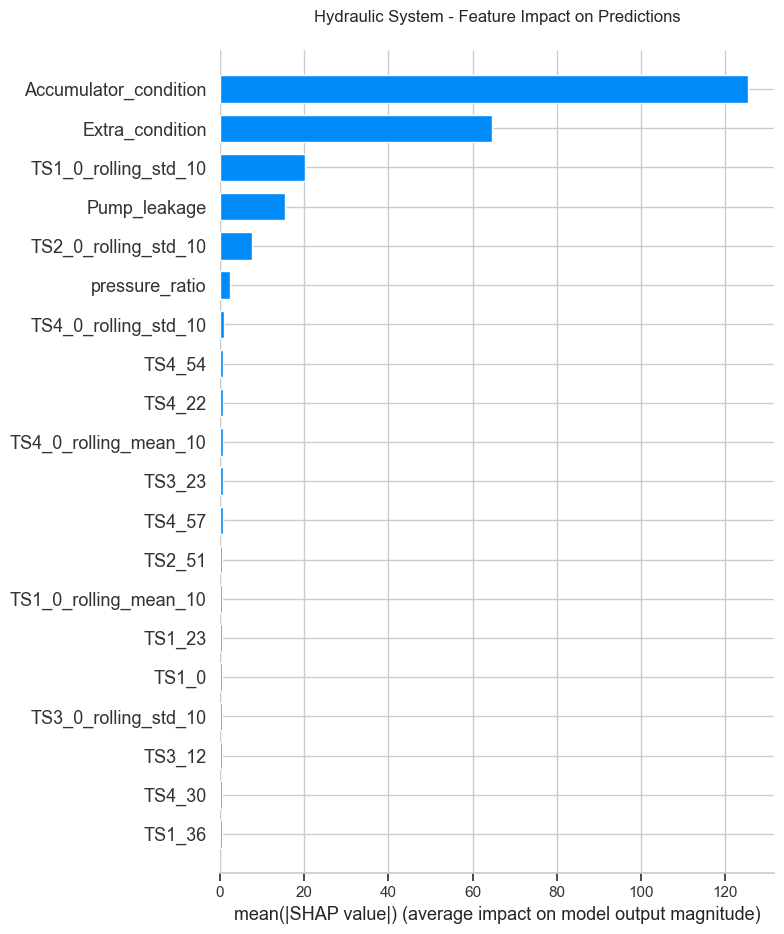


=== Individual Prediction Analysis ===


<Figure size 1200x400 with 0 Axes>

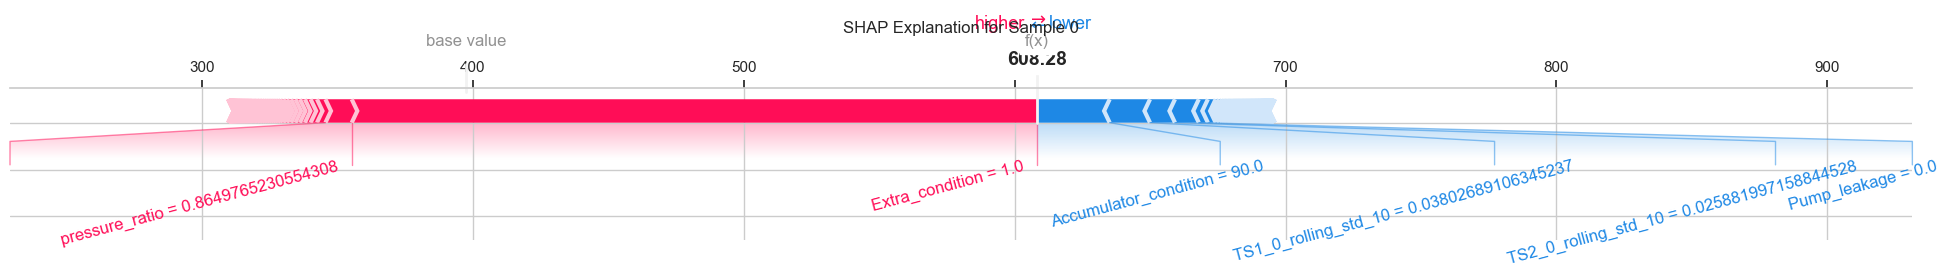


=== Pressure-Temperature Interactions ===


<Figure size 1000x600 with 0 Axes>

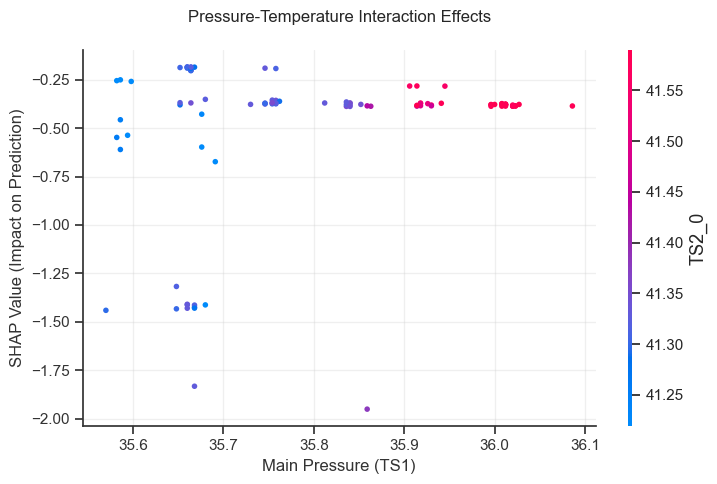

In [61]:
# ======================
# MODEL INTERPRETATION (SHAP)
# ======================

try:
    import shap
    import matplotlib.pyplot as plt
    
    # Check if model and test data exist
    if 'model' not in globals():
        raise RuntimeError("No trained model found. Run model training cells first.")
    if 'X_test' not in globals() or len(X_test) == 0:
        raise RuntimeError("Test data not found or empty. Check data preparation steps.")
    
    # Initialize SHAP explainer
    try:
        explainer = shap.TreeExplainer(model)
        print(f"Model expected value (base value): {explainer.expected_value[0]:.2f}")
    except Exception as e:
        raise RuntimeError(f"SHAP explainer initialization failed: {str(e)}")
    
    # Sample data for faster computation (adjust sample size as needed)
    sample_size = min(100, len(X_test))
    X_sample = X_test.iloc[:sample_size]
    
    # Calculate SHAP values
    try:
        shap_values = explainer.shap_values(X_sample)
        if isinstance(shap_values, list):  # Handle multi-class case
            shap_values = shap_values[0]  # Use first class for binary classification
    except Exception as e:
        raise RuntimeError(f"SHAP value calculation failed: {str(e)}")
    
    # ===== GLOBAL FEATURE IMPORTANCE =====
    print("\n=== Global Feature Importance ===")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title("Hydraulic System - Feature Impact on Predictions", pad=20)
    plt.tight_layout()
    plt.show()
    
    # ===== INDIVIDUAL PREDICTION EXPLANATION =====
    print("\n=== Individual Prediction Analysis ===")
    sample_idx = 0  # First test sample
    plt.figure(figsize=(12, 4))
    shap.force_plot(
        explainer.expected_value[0], 
        shap_values[sample_idx, :], 
        X_sample.iloc[sample_idx, :],
        matplotlib=True,
        text_rotation=15,
        show=False
    )
    plt.title(f"SHAP Explanation for Sample {sample_idx}", pad=20)
    plt.tight_layout()
    plt.show()
    
    # ===== FEATURE DEPENDENCY PLOTS =====
    print("\n=== Pressure-Temperature Interactions ===")
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        "TS1_0", 
        shap_values, 
        X_sample,
        interaction_index="TS2_0", 
        show=False
    )
    plt.xlabel("Main Pressure (TS1)", fontsize=12)
    plt.ylabel("SHAP Value (Impact on Prediction)", fontsize=12)
    plt.title("Pressure-Temperature Interaction Effects", pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("SHAP library not installed! Run `!pip install shap` and restart kernel.")
except Exception as e:
    print(f"Error during SHAP analysis: {str(e)}")

10. Comprehensive Reporting